<a href="https://colab.research.google.com/github/Natalia409634/Grupo7-practica2-ML/blob/main/G7_P2_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

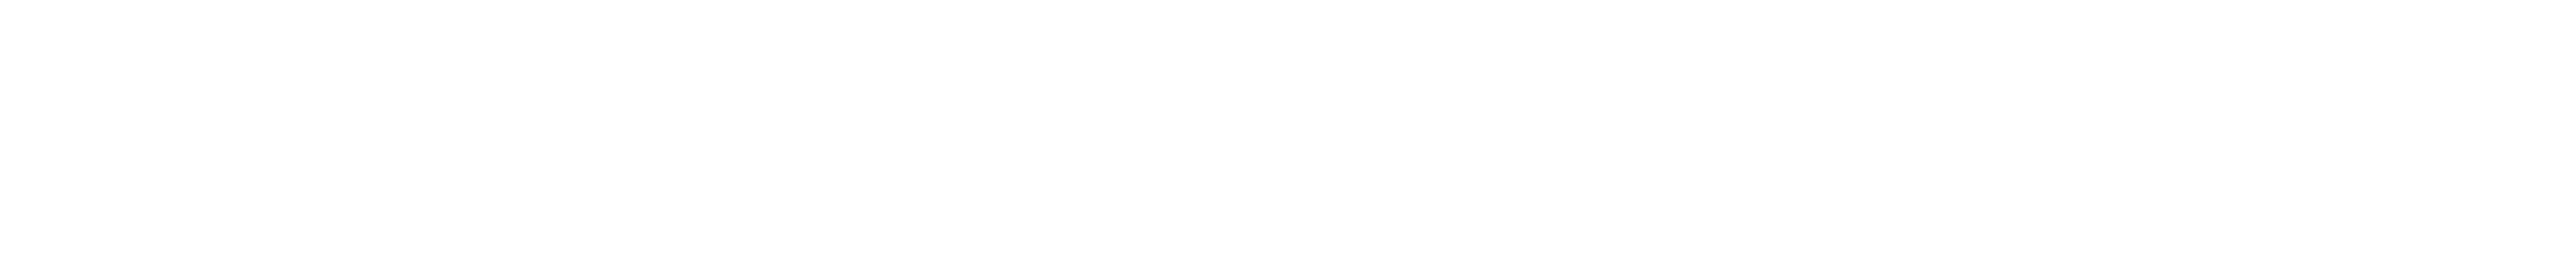

# **PRÁCTICA 2: PREDICCIÓN DEL ABANDONO DE EMPLEADOS**

Aprendizaje Automático - Grupo 7

*   Andrés Felipe Camacho Martínez - 100408821
*   Natalia Jiménez Barrigüete - 100409634


# Librerías

In [37]:
from google.colab import drive
drive.mount('/content/drive')
import pickle
import os
import time

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
import plotly.express as px
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif, mutual_info_regression




# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Lectura de Datos

Los datos están en formato 'pkl'

In [38]:
# Carga el archivo pkl en un DataFrame de Pandas
data_df = pd.read_pickle('/content/drive/MyDrive/Aprendizaje Automático/practica 2/datos_grupos/attrition_available_7.pkl')

Edición visual de los datos

In [39]:
def set_frame_style(df, caption=""):
    """Helper function to set dataframe presentation style.
    """
    return df.style.background_gradient(cmap='Blues').set_caption(caption).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'darkblue'),
        ('font-size', '18px'),
        ('font-weight','bold')
    ]}])

# EDA Simplificado

Se trata de un **problema de clasificación**, ya que la variable de salida que se espera del modelo es categórica, es decir, se espera que el modelo prediga si un empleado abandonará o no la empresa en un futuro cercano

## 1. Análisis de variables

In [40]:
data_df.head()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,7.315971,13.0,2.0,NaN,3.0,2.0,NaN,31.0,Yes,Travel_Frequently,...,0.0,Y,NaN,NaN,1,6.0,3.0,5.0,1.0,4.0
6,6.450877,17.0,3.0,4.0,1.0,3.0,1.0,28.0,Yes,Travel_Rarely,...,2.0,Y,20.0,NaN,1,5.0,2.0,0.0,0.0,0.0
13,8.871421,14.0,2.0,3.0,1.0,2.0,2.0,47.0,Yes,NaN,...,1.0,Y,NaN,8.0,2,10.0,4.0,10.0,9.0,9.0
28,10.713066,6.0,2.0,3.0,4.0,3.0,1.0,44.0,Yes,Travel_Frequently,...,3.0,Y,14.0,8.0,1,19.0,2.0,1.0,0.0,0.0
30,9.662808,11.0,2.0,NaN,1.0,2.0,NaN,26.0,Yes,Travel_Rarely,...,2.0,Y,NaN,8.0,0,5.0,5.0,3.0,0.0,2.0


In [41]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 1 to 4409
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      3588 non-null   float64
 1   absences                 3663 non-null   float64
 2   JobInvolvement           3542 non-null   float64
 3   PerformanceRating        3684 non-null   float64
 4   EnvironmentSatisfaction  4385 non-null   float64
 5   JobSatisfaction          3484 non-null   float64
 6   WorkLifeBalance          3526 non-null   float64
 7   Age                      3678 non-null   float64
 8   Attrition                4410 non-null   object 
 9   BusinessTravel           3452 non-null   object 
 10  Department               3553 non-null   object 
 11  DistanceFromHome         3569 non-null   float64
 12  Education                3676 non-null   float64
 13  EducationField           3441 non-null   object 
 14  EmployeeCount           

El conjunto de datos proporcionado tiene 30 atributos, los cuales adoptan un formato: 'float64', 'int64' y 'object'.

Hemos detectado una anomalía y es que la variable "StockOptionLevel" en nuestro dataset es de tipo "int64" cuando según la documentación debería ser de tipo "float64". De cara al posterior tratamiento de las Missing Values hemos decidio transformarla a tipo "float64".

In [42]:
data_df["StockOptionLevel"] = data_df["StockOptionLevel"].astype(float)

In [43]:
cols = data_df.columns.to_list()

display(set_frame_style(data_df[cols].head(),'Primeros'))

display(set_frame_style(data_df[cols].describe(),'Resumen de estadistica'))

display(set_frame_style(data_df[cols].isna().any().to_frame().transpose(), 'Columnas con valor nulo'))

display(set_frame_style(data_df[cols].nunique().to_frame().rename({0:'Numero de valores únicos'}, axis=1).transpose(), 'Valores únicos en cada variable'))

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,7.315971,13.000000,2.000000,nan,3.000000,2.000000,nan,31.000000,Yes,Travel_Frequently,Research & Development,10.000000,1.000000,Life Sciences,1.000000,2,Female,nan,Research Scientist,Single,41890.000000,0.000000,Y,nan,nan,1.000000,6.000000,3.000000,5.000000,1.000000,4.000000
6,6.450877,17.000000,3.000000,4.000000,1.000000,3.000000,1.000000,28.000000,Yes,Travel_Rarely,nan,11.000000,2.000000,Medical,1.000000,7,Male,2.000000,nan,Single,58130.000000,2.000000,Y,20.000000,nan,1.000000,5.000000,2.000000,0.000000,0.000000,0.000000
13,8.871421,14.000000,2.000000,3.000000,1.000000,2.000000,2.000000,47.000000,Yes,nan,Research & Development,1.000000,1.000000,Medical,1.000000,14,Male,1.000000,Research Scientist,Married,57620.000000,1.000000,Y,nan,8.000000,2.000000,10.000000,4.000000,10.000000,9.000000,9.000000
28,10.713066,6.000000,2.000000,3.000000,4.000000,3.000000,1.000000,44.000000,Yes,Travel_Frequently,Research & Development,1.000000,2.000000,Medical,1.000000,29,Male,2.000000,Research Scientist,Divorced,103330.000000,3.000000,Y,14.000000,8.000000,1.000000,19.000000,2.000000,1.000000,0.000000,0.000000
30,9.662808,11.000000,2.000000,nan,1.000000,2.000000,nan,26.000000,Yes,Travel_Rarely,Research & Development,4.000000,nan,Medical,1.000000,31,Male,3.000000,Research Scientist,nan,nan,2.000000,Y,nan,8.000000,0.000000,5.000000,5.000000,3.000000,0.000000,2.000000


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,3588.000000,3663.000000,3542.000000,3684.000000,4385.000000,3484.000000,3526.000000,3678.000000,3569.000000,3676.000000,3561.000000,4410.000000,3566.000000,3448.000000,3646.000000,3457.000000,3465.000000,4410.000000,3514.000000,3700.000000,3628.000000,3652.000000,3665.000000
mean,7.325269,12.731095,2.723038,3.155266,2.723603,2.733639,2.758934,36.942360,9.177641,2.909412,1.000000,2205.500000,2.046831,65417.700116,2.715030,15.244721,8.000000,0.793878,11.268355,2.795676,6.995039,2.204272,4.116235
std,1.332110,5.531700,0.718360,0.362207,1.092756,1.095605,0.701183,9.124196,8.093058,1.023644,0.000000,1273.201673,1.094571,47530.589620,2.511696,3.682925,0.000000,0.851883,7.785224,1.290212,6.084324,3.244261,3.557025
min,5.416880,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10090.000000,0.000000,11.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.295553,8.000000,2.000000,3.000000,2.000000,2.000000,2.000000,30.000000,2.000000,2.000000,1.000000,1103.250000,1.000000,29290.000000,1.000000,12.000000,8.000000,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,7.018052,13.000000,3.000000,3.000000,3.000000,3.000000,3.000000,36.000000,7.000000,3.000000,1.000000,2205.500000,2.000000,49330.000000,2.000000,14.000000,8.000000,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,7.912442,17.000000,3.000000,3.000000,4.000000,4.000000,3.000000,43.000000,14.000000,4.000000,1.000000,3307.750000,3.000000,84120.000000,4.000000,18.000000,8.000000,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000
max,10.937261,24.000000,4.000000,4.000000,4.000000,4.000000,4.000000,60.000000,29.000000,5.000000,1.000000,4410.000000,5.000000,199990.000000,9.000000,25.000000,8.000000,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,True,True,True


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
Numero de valores únicos,3585,24,4,2,4,4,4,43,2,3,3,29,5,6,1,4410,2,5,9,3,1337,10,1,15,1,4,40,7,37,16,18


## 2. Eliminación de variables

Procedemos a eliminar las variables constantes, es decir, cuya Desviación Típica (std) es igual a 0

In [44]:
data_df = data_df.drop(['Over18'], axis=1)

In [45]:
data_df = data_df.drop(['StandardHours'], axis=1)

In [46]:
data_df = data_df.drop(['EmployeeCount'], axis=1)

Por otro lado, eliminamos variables que consideramos innecesarias

In [47]:
data_df = data_df.drop(['EmployeeID'], axis=1)

## 3. Missing Values

Identificación y proporción de Missing Values

In [48]:
missing_values_count = data_df.isnull().sum().sort_values(ascending=False)
prop_miss = data_df.isna().mean().sort_values(ascending=False)

missing_props_df = pd.concat([missing_values_count, prop_miss], axis=1, keys=['Missing Values Count', 'Proportion Missing'])

print(missing_props_df)

                         Missing Values Count  Proportion Missing
EducationField                            969            0.219728
MonthlyIncome                             962            0.218141
BusinessTravel                            958            0.217234
PercentSalaryHike                         953            0.216100
JobSatisfaction                           926            0.209977
TotalWorkingYears                         896            0.203175
WorkLifeBalance                           884            0.200454
JobInvolvement                            868            0.196825
Department                                857            0.194331
JobLevel                                  844            0.191383
DistanceFromHome                          841            0.190703
hrs                                       822            0.186395
YearsAtCompany                            782            0.177324
NumCompaniesWorked                        764            0.173243
MaritalSta

Aquí se puede encontrar el numero de datos faltantes ordenadors de mayor a menos por atributo. Las columnas más incompletas son EducationField, MonthlyIncome Y BusinessTravel. **menos datos = menos precisión**

Asimismo, tambien se muestra la proporción de valores faltantes en cada columna del DataFrame.

Por ejemplo, para la columna "hrs" la proporción de valores faltantes es del 18.64%, lo que significa que aproximadamente el 18.64% de los valores en esa columna están faltando. De manera similar, para la columna "absences", la proporción de valores faltantes es del 16.94%, lo que significa que alrededor del 16.94% de los valores en esa columna están faltando.

También se puede observar como los atributos 'Attrition' y 'StockOptionLevel' tienen un valor de 0.00, lo que implica que estan presentes todos los valores 

### 3.1 Clasificación de variables

In [49]:
data_type = data_df.dtypes
print(data_type)

hrs                        float64
absences                   float64
JobInvolvement             float64
PerformanceRating          float64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                        float64
Attrition                   object
BusinessTravel              object
Department                  object
DistanceFromHome           float64
Education                  float64
EducationField              object
Gender                      object
JobLevel                   float64
JobRole                     object
MaritalStatus               object
MonthlyIncome              float64
NumCompaniesWorked         float64
PercentSalaryHike          float64
StockOptionLevel           float64
TotalWorkingYears          float64
TrainingTimesLastYear      float64
YearsAtCompany             float64
YearsSinceLastPromotion    float64
YearsWithCurrManager       float64
dtype: object


El conjunto de datos tras el tratamiento tiene 26 atributos, con datos de tipo: 'float64' y 'object'

In [50]:
cols = data_df.columns.to_list()
display(set_frame_style(data_df[cols].describe(),'Resumen de estadistica'))
display(set_frame_style(data_df[cols].nunique().to_frame().rename({0:'Numero de valores únicos'}, axis=1).transpose(), 'Valores únicos en cada variable'))

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,3588.000000,3663.000000,3542.000000,3684.000000,4385.000000,3484.000000,3526.000000,3678.000000,3569.000000,3676.000000,3566.000000,3448.000000,3646.000000,3457.000000,4410.000000,3514.000000,3700.000000,3628.000000,3652.000000,3665.000000
mean,7.325269,12.731095,2.723038,3.155266,2.723603,2.733639,2.758934,36.942360,9.177641,2.909412,2.046831,65417.700116,2.715030,15.244721,0.793878,11.268355,2.795676,6.995039,2.204272,4.116235
std,1.332110,5.531700,0.718360,0.362207,1.092756,1.095605,0.701183,9.124196,8.093058,1.023644,1.094571,47530.589620,2.511696,3.682925,0.851883,7.785224,1.290212,6.084324,3.244261,3.557025
min,5.416880,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,1.000000,10090.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.295553,8.000000,2.000000,3.000000,2.000000,2.000000,2.000000,30.000000,2.000000,2.000000,1.000000,29290.000000,1.000000,12.000000,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,7.018052,13.000000,3.000000,3.000000,3.000000,3.000000,3.000000,36.000000,7.000000,3.000000,2.000000,49330.000000,2.000000,14.000000,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,7.912442,17.000000,3.000000,3.000000,4.000000,4.000000,3.000000,43.000000,14.000000,4.000000,3.000000,84120.000000,4.000000,18.000000,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000
max,10.937261,24.000000,4.000000,4.000000,4.000000,4.000000,4.000000,60.000000,29.000000,5.000000,5.000000,199990.000000,9.000000,25.000000,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
Numero de valores únicos,3585,24,4,2,4,4,4,43,2,3,3,29,5,6,2,5,9,3,1337,10,15,4,40,7,37,16,18


In [51]:
count = {'Categóricos': [], 'Ordinales': [], 'Numéricos': []}
for nombre, valor in data_type.items():
  if valor == 'object': count['Categóricos'].append(nombre)
  if valor == 'float64':
    if (data_df[nombre].min() >= 0 and data_df[nombre].min() <= 1) and (data_df[nombre].max() >= 3 and data_df[nombre].max() <= 5):
      count['Ordinales'].append(nombre)
    else:
      count['Numéricos'].append(nombre)

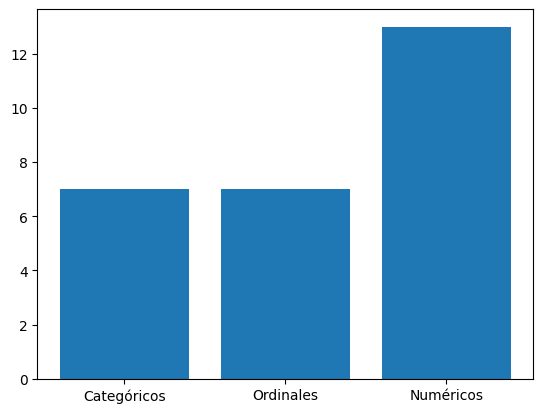

In [52]:
claves = list(count.keys())
cantidades = [len(valores) for valores in count.values()]
plt.bar(claves, cantidades)
plt.show()

### 3.2 Tratamiento de Missing Values

Sustituiremos los Missing Values por la media en las variables numéricas, por la moda en las categóricas y en las ordinales.

Contamos con variables categóricas binomiales, "Gender" y "Atrittion", las cuales transformaremos para que tomen valores o bien 0 o bien 1. 

In [53]:
for col in count['Numéricos']:
  mean = np.nanmean(data_df[col])
  data_df.loc[np.isnan(data_df[col]), col] = mean

In [54]:
for col in count['Ordinales']:
  mode = data_df[col].mode()[0]
  data_df.loc[data_df[col].isnull(), col] = mode

In [55]:
for col in count['Categóricos']:
  mode = data_df[col].mode()[0]
  data_df.loc[data_df[col].isnull(), col] = mode

#### 3.2.1 Variables categóricas binomiales "Gender" y "Atrittion"

In [56]:
new_atrittion = {'No': 0, 'Yes': 1}
new_gender = {'Male': 0, 'Female': 1}

data_df['Attrition'] = data_df['Attrition'].replace(new_atrittion)
data_df['Gender'] = data_df['Gender'].replace(new_gender)

#### 3.2.2 Resto de variables categóricas, aplicación de One Hot Encoder

In [57]:
from sklearn.preprocessing import OneHotEncoder

columns_to_encode = ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus']

encoder = OneHotEncoder()

encoded_data = encoder.fit_transform(data_df[columns_to_encode])

categories = encoder.categories_

new_columns = []
for i, column in enumerate(columns_to_encode):
    for category in categories[i]:
        new_columns.append(f"{column}_{category}")

encoded_data = encoded_data.toarray()
encoded_df = pd.DataFrame(encoded_data, columns=new_columns)

data_df = pd.concat([data_df.drop(columns_to_encode, axis=1), encoded_df], axis=1)

## 4. ¿El problema está balanceado?

In [58]:
# Número de muestras por clase
data_df.Attrition.value_counts().sort_index()

0    3699
1     711
Name: Attrition, dtype: int64

Tenemos 3699 muestras que no han dejado la empresa y 711 que sí han dejado la empresa. Por lo que el problema se encuentra desbalanceado.

## 5. Separación en conjuntos

Seguirá la siguiente distribución:

*   Cojunto de entrenamiento [X_train, y_train]
*   Conjunto de validación [X_valid, y_valid]
*   Conjunto de test [X_test, y_test]

In [59]:
from sklearn.model_selection import train_test_split

X = data_df.drop('Attrition', axis=1)
y = data_df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=7)

Realizamos la separación en conjuntos empleando train_test_split siguiendo las recomendaciones del profesor dadas en clase.

# Modelos

## Logistic Regression

In [60]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

X_train_std = sc_X.fit_transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns=data_df.columns.values[:-1])

In [61]:
sc_X = StandardScaler()

X_test_std = sc_X.fit_transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns=data_df.columns.values[:-1])

Balanced accuracy:  0.6678685643362535
F1 score:  0.41004184100418406
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78       731
           1       0.30      0.65      0.41       151

    accuracy                           0.68       882
   macro avg       0.60      0.67      0.60       882
weighted avg       0.80      0.68      0.72       882



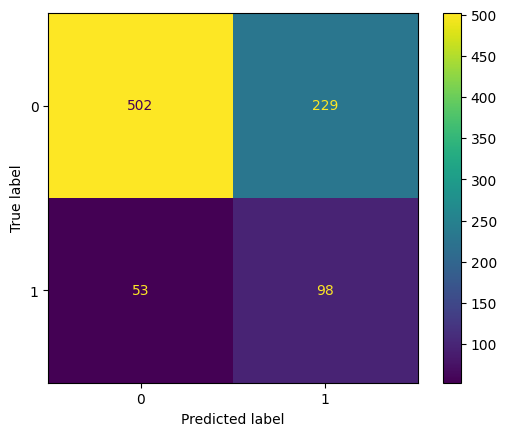

In [62]:
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import metrics

lr = LogisticRegression(random_state = 7, class_weight="balanced")

# Entrenamos
start = time.time()
lr.fit(X_train_std, y_train)
lr_time = time.time() - start

y_pred = lr.predict(X_test_std)

balanced_acc_1 = balanced_accuracy_score(y_test, y_pred)

f1_1 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.grid(False)

print("Balanced accuracy: ", balanced_acc_1)
print("F1 score: ", f1_1)
print("Classification Report:",)
print(classification_report(y_test, y_pred))

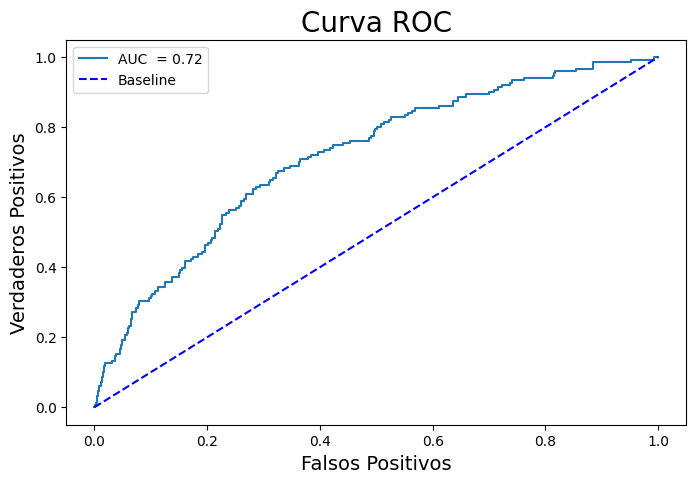

In [63]:
probs = lr.predict_proba(X_test_std)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

El AUC obtenido es de 0.72, lo que indica que el modelo tiene un rendimiento moderado en la clasificación de las dos clases. Es decir, el modelo es capaz de distinguir entre los casos positivos y negativos con una precisión moderada.

La curva ROC representa la relación entre la tasa de verdaderos positivos (sensibilidad) y la tasa de falsos positivos (especificidad) en diferentes umbrales de clasificación. Un punto en la curva ROC representa la sensibilidad y la especificidad del modelo en un umbral de clasificación particular. El AUC es el área bajo la curva ROC y proporciona una medida del rendimiento global del modelo.

En resumen, un AUC de 0.72 indica que el modelo tiene un rendimiento moderado en la clasificación binaria y hay margen de mejora para mejorar su precisión.

## Gradient Boosting

### Hiperparámetros por omisión

Balanced accuracy:  0.6151013308449824
F1 score:  0.37305699481865284
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       731
           1       0.86      0.24      0.37       151

    accuracy                           0.86       882
   macro avg       0.86      0.62      0.65       882
weighted avg       0.86      0.86      0.83       882



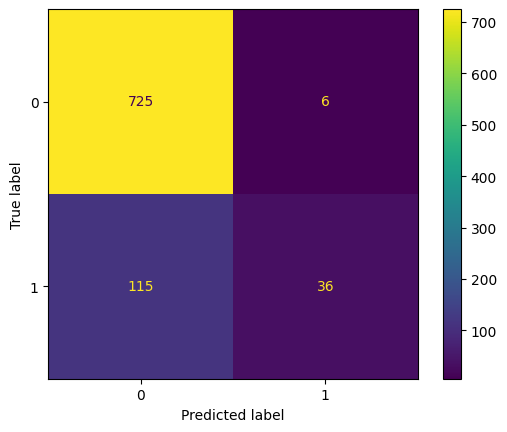

In [64]:
from sklearn.ensemble import GradientBoostingClassifier

boo = GradientBoostingClassifier(random_state=7)

# Entrenamos
start = time.time()
boo.fit(X_train, y_train)
boo_time = time.time() - start

y_pred = boo.predict(X_test)

ba_2 = balanced_accuracy_score(y_test, y_pred)

f1_2 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.grid(False)

print("Balanced accuracy: ", ba_2)
print("F1 score: ", f1_2)
print("Classification Report:",)
print(classification_report(y_test, y_pred))

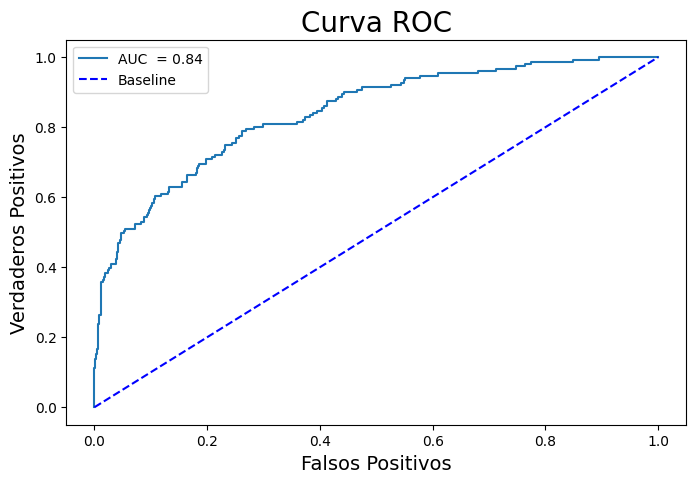

In [65]:
probs = boo.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

### Ajuste de hiperparámetros

El ajuste de hiperparámetros es un proceso crucial en el desarrollo de modelos de aprendizaje automático, ya que los hiperparámetros son parámetros que se establecen antes de entrenar el modelo y que afectan directamente al rendimiento y la capacidad del modelo para generalizar a nuevos datos. El objetivo del ajuste de hiperparámetros es encontrar el conjunto óptimo de valores de hiperparámetros que permitan al modelo alcanzar el mejor rendimiento posible.

In [66]:
boo_opt = GradientBoostingClassifier(random_state=7)

param_grid = {
    'learning_rate': [0.001, 0.05, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

boo_regr = RandomizedSearchCV(
    estimator=boo_opt, 
    param_distributions=param_grid, 
    n_iter=5, 
    cv=3, 
    verbose=2, 
    random_state=1, 
    n_jobs=-1
)

boo_regr.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=7),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.05, 0.1,
                                                          0.2],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 500, 1000]},
                   random_state=1, verbose=2)

In [67]:
print("Mejores hiperparámetros:")
print(boo_regr.best_params_)

Mejores hiperparámetros:
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 7, 'learning_rate': 0.05}


Estos hiperparámetros fueron obtenidos mediante un proceso de ajuste en el que se probaron diferentes combinaciones de valores para optimizar el rendimiento del modelo de aprendizaje automático en el problema en cuestión. E**l resultado indica que los mejores hiperparámetros encontrados fueron un valor de n_estimators de 500, min_samples_split de 5, min_samples_leaf de 1, max_depth de 7 y learning_rate de 0.05.**



Balanced accuracy:  0.7846594975584567
F1 score:  0.7160493827160493
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       731
           1       0.95      0.58      0.72       151

    accuracy                           0.92       882
   macro avg       0.93      0.78      0.84       882
weighted avg       0.92      0.92      0.91       882



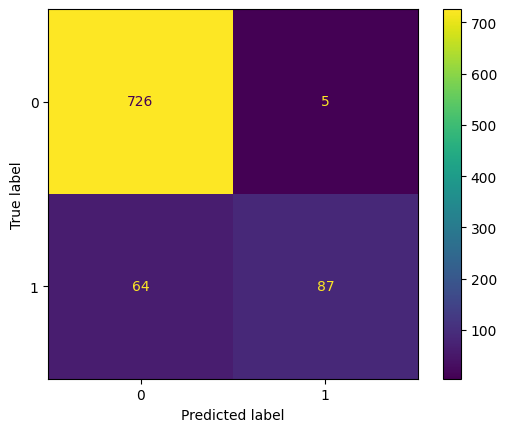

In [68]:
best_model_boost = boo_regr.best_estimator_

# Entrenamos
start = time.time()
best_model_boost.fit(X_train, y_train)
boo_opt_time = time.time() - start

y_pred = best_model_boost.predict(X_test)

ba = balanced_accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.grid(False)

print("Balanced accuracy: ", ba)
print("F1 score: ", f1)
print("Classification Report:",)
print(classification_report(y_test, y_pred))

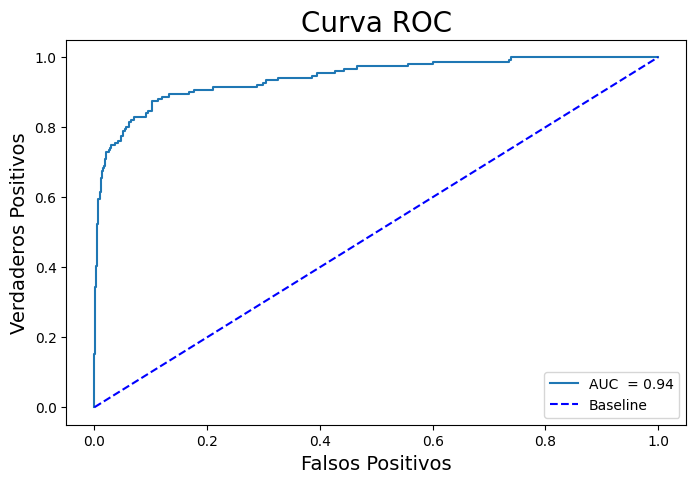

In [69]:
probs = best_model_boost.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

En primer lugar, se utiliza el modelo entrenado best_model_boost para predecir las probabilidades de la clase positiva para los datos de prueba (X_test). El atributo predict_proba del modelo devuelve la probabilidad de pertenecer a cada una de las clases. Como se trata de un problema de clasificación binaria, se utiliza la probabilidad de la clase positiva, que se encuentra en la segunda columna (índice 1) de la matriz de probabilidades. Por lo tanto, la línea de código probs = best_model_boost.predict_proba(X_test)[:, 1] extrae las probabilidades de la clase positiva.

A continuación, se calcula el AUC utilizando la función roc_auc_score de sklearn.metrics. La función roc_auc_score toma como entrada las etiquetas reales de los datos de prueba (y_test) y las probabilidades de la clase positiva (probs) y devuelve el AUC.

Finalmente, se calcula la curva ROC utilizando la función roc_curve de sklearn.metrics. La función roc_curve toma como entrada las etiquetas reales de los datos de prueba (y_test) y las probabilidades de la clase positiva (probs) y devuelve tres arrays: la tasa de falsos positivos (fpr), la tasa de verdaderos positivos (tpr) y los umbrales utilizados para calcular las tasas. La curva ROC se grafica trazando la tasa de verdaderos positivos (tpr) en el eje y, y la tasa de falsos positivos (fpr) en el eje x.

La última parte del código grafica la curva ROC y la línea de base (línea diagonal punteada que representa el rendimiento aleatorio del modelo). La leyenda de la gráfica incluye el valor del AUC. La curva ROC muestra la relación entre la sensibilidad (tasa de verdaderos positivos) y la especificidad (tasa de verdaderos negativos) en diferentes umbrales de clasificación. Cuanto mayor sea el AUC, mejor será el rendimiento del modelo para la clasificación binaria.

**Un AUC (área bajo la curva ROC) de 0.94 indica que el modelo tiene un excelente rendimiento en la clasificación binaria. **

## Xgboost

### Hiperparámetros por omisión

Balanced accuracy:  0.7507542058868827
F1 score:  0.65
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       731
           1       0.88      0.52      0.65       151

    accuracy                           0.90       882
   macro avg       0.89      0.75      0.80       882
weighted avg       0.90      0.90      0.89       882



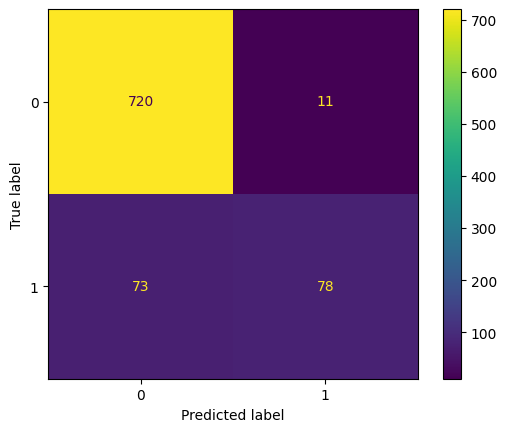

In [70]:
from xgboost import XGBClassifier

xg = XGBClassifier(random_state=7)

# Entrenamos
start = time.time()
xg.fit(X_train, y_train)
xg_time = time.time() - start

y_pred = xg.predict(X_test)

ba_3 = balanced_accuracy_score(y_test, y_pred)

f1_3 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.grid(False)

print("Balanced accuracy: ", ba_3)
print("F1 score: ", f1_3)
print("Classification Report:",)
print(classification_report(y_test, y_pred))

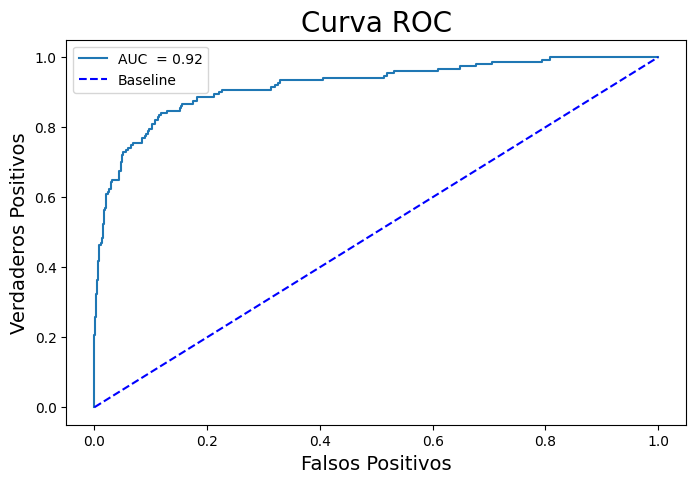

In [71]:
probs = xg.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

[link text](https://)### Ajuste de hiperparámetro

In [72]:
xg = XGBClassifier(random_state=7)

param_grid = {
    'learning_rate': [0.001, 0.05, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

xg_regr = RandomizedSearchCV(
    estimator=boo_opt, 
    param_distributions=param_grid, 
    n_iter=20, 
    cv=3, 
    verbose=2, 
    random_state=1, 
    n_jobs=-1
)

xg_regr.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=7),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.05, 0.1,
                                                          0.2],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 500, 1000]},
                   random_state=1, verbose=2)

In [73]:
print("Mejores hiperparámetros:")
print(xg_regr.best_params_)

Mejores hiperparámetros:
{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.2}


Balanced accuracy:  0.8071543109774326
F1 score:  0.7490039840637449
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       731
           1       0.94      0.62      0.75       151

    accuracy                           0.93       882
   macro avg       0.93      0.81      0.85       882
weighted avg       0.93      0.93      0.92       882



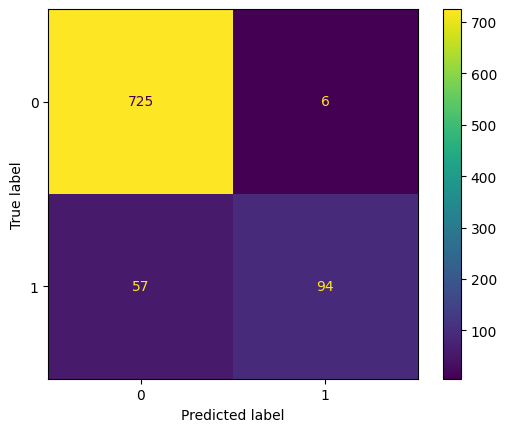

In [74]:
best_model_xg = xg_regr.best_estimator_

# Entrenamos
start = time.time()
best_model_xg.fit(X_train, y_train)
boo_opt_time = time.time() - start

y_pred = best_model_xg.predict(X_test)

ba_4 = balanced_accuracy_score(y_test, y_pred)

f1_4 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.grid(False)

print("Balanced accuracy: ", ba_4)
print("F1 score: ", f1_4)
print("Classification Report:",)
print(classification_report(y_test, y_pred))

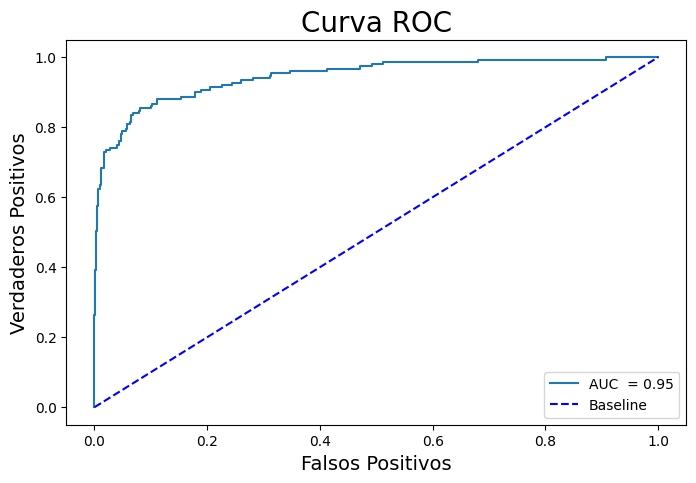

In [75]:
probs = best_model_xg.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

# Métodos de selección de atributos

## Selección de atributos con chi 2

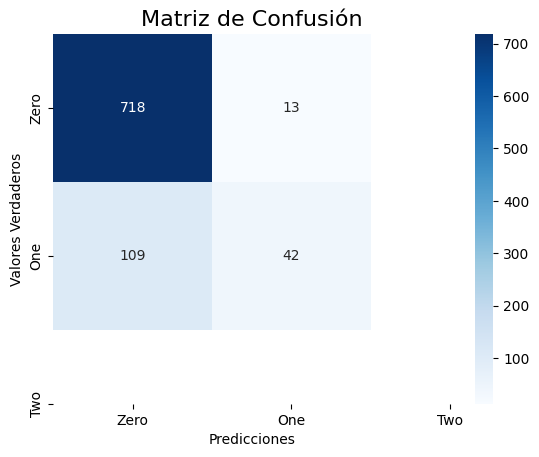

NameError: ignored

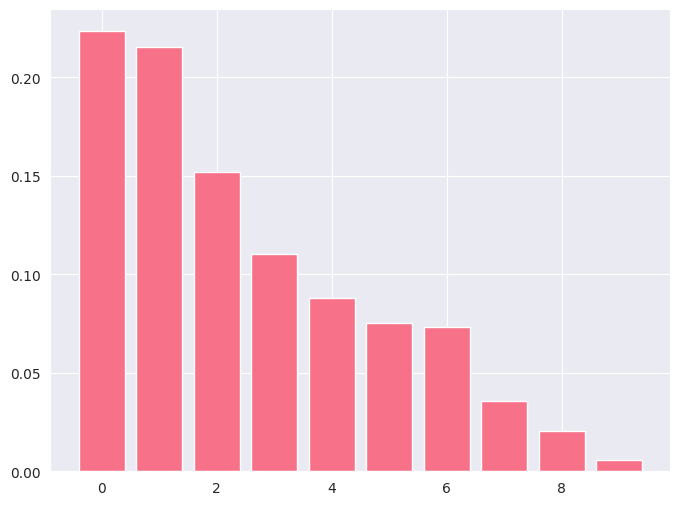

In [76]:
#num de caracteristicas
k = 10
selector = SelectKBest(score_func=chi2, k=k)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)


#entrenamiento
gb = GradientBoostingClassifier(n_estimators=500, min_samples_split=5, min_samples_leaf=1, learning_rate=0.05)
gb.fit(X_train_selected, y_train)

#predicciones
y_pred = gb.predict(X_test_selected)


ba = balanced_accuracy_score(y_test, y_pred, sample_weight=None)
f1 = f1_score(y_test, y_pred, average='macro', sample_weight=None)

#matriz de confusión
cm = confusion_matrix(y_test, y_pred)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One', 'Two']
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=categories, yticklabels=categories, ax=ax)
ax.set_xlabel('Predicciones')
ax.set_ylabel('Valores Verdaderos')
ax.set_title('Matriz de Confusión', fontsize=16)
plt.show()

print("===================================")

# características mas importantes
importances = gb.feature_importances_

indices = np.argsort(importances)[::-1]
sns.set_style('darkgrid')
sns.set_palette("husl", X_train_selected.shape[1])
plt.figure(figsize=(8, 6))
plt.bar(range(X_train_selected.shape[1]), importances[indices])
plt.xticks(range(X_train_selected.shape[1]), [selected_feature_names[i] for i in indices], rotation=90)

plt.xlim([-1, X_train_selected.shape[1]])
plt.title('Importancia de Características', fontsize=16)
plt.xlabel('Características', fontsize=14)
plt.ylabel('Importancia', fontsize=14)
plt.show()


print("===================================")
print(f"Balanced Accuracy: {ba:.4f}")
print(f"F1: {f1:.4f}")
print()
print(classification_report(y_test, y_pred))


En la matriz de confusión, los valores de la diagonal principal representan el número de predicciones correctas para cada clase. La celda superior izquierda representa el número de verdaderos positivos (TP), es decir, el número de casos en los que el modelo predijo correctamente la clase positiva; en nuestro caso es de 718. La celda inferior derecha representa el número de verdaderos negativos (TN), es decir, el número de casos en los que el modelo predijo correctamente la clase negativa.

Por otro lado, los valores fuera de la diagonal principal representan el número de errores de predicción para cada clase. La celda superior derecha representa el número de falsos positivos (FP), es decir, el número de casos en los que el modelo predijo incorrectamente la clase positiva. La celda inferior izquierda representa el número de falsos negativos (FN), es decir, el número de casos en los que el modelo predijo incorrectamente la clase negativa.

Respecto al diagrama de barras, el eje x muestra los nombres de las características, y el eje y muestra la importancia de cada una de ellas. En este caso, se han ordenado las características de mayor a menor importancia, por lo que las primeras características de la izquierda son las más importantes.

Las 3 caracteristicas más importantes son 'TotalWorkingYears', 'Age' y 'Monthlyincome'

In [ ]:
# características chi2
selector = SelectKBest(score_func=chi2, k=k)
selector.fit(X_train, y_train)
selected_features = selector.get_support(indices=True)
feature_names = X_train.columns
selected_feature_names = [feature_names[i] for i in selected_features]


print("Selección de características con f_classif")
print("===================================")
print("Número de características seleccionadas: ", len(selected_feature_names), "\n")
print("Características seleccionadas:")
selected_feature_names.sort()
for i, feature in enumerate(selected_feature_names):
    print(f"{i+1}. {textwrap.fill(feature, width=50)}")

Chi 2:Podemos observar como la puntuación F1 obtenida es de 0.6647 y el accuracy es de 6.302

## Selección de atributos con f_classif

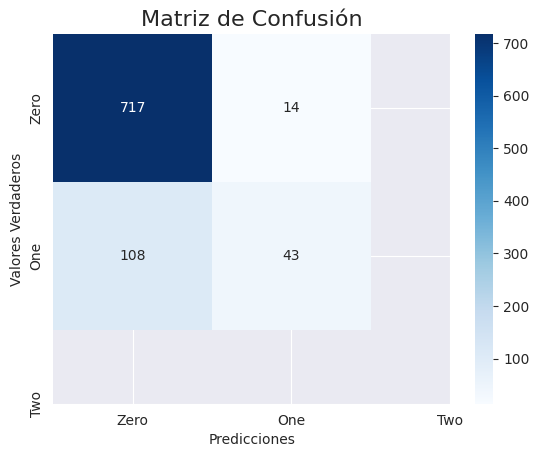

NameError: ignored

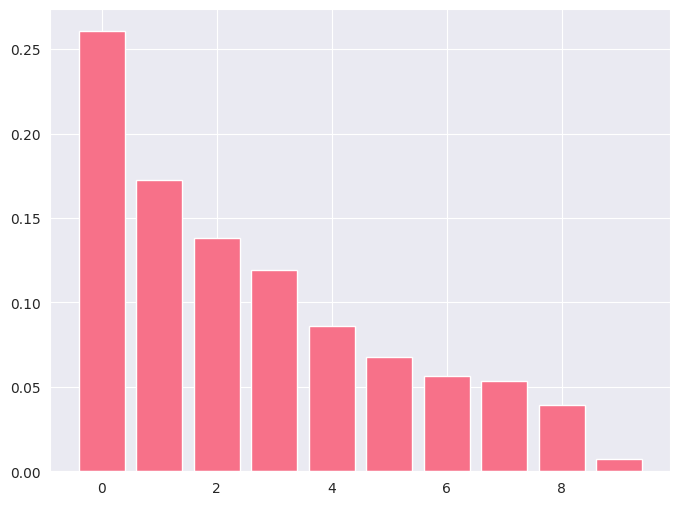

In [77]:
# num de características
k = 10 
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Entrenamiento
gb_fc = GradientBoostingClassifier(n_estimators=500, min_samples_split=5, min_samples_leaf=1, learning_rate=0.05)
gb_fc.fit(X_train_selected, y_train)


y_pred_fc = gb_fc.predict(X_test_selected)

ba = balanced_accuracy_score(y_test, y_pred_fc, sample_weight=None)
f1 = f1_score(y_test, y_pred_fc, average='macro', sample_weight=None)

# matriz de confusión
cm = confusion_matrix(y_test, y_pred_fc)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One', 'Two']
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=categories, yticklabels=categories, ax=ax)
ax.set_xlabel('Predicciones')
ax.set_ylabel('Valores Verdaderos')
ax.set_title('Matriz de Confusión', fontsize=16)
plt.show()

print("===================================")

importances = gb_fc.feature_importances_
indices = np.argsort(importances)[::-1]
sns.set_style('darkgrid')
sns.set_palette("husl", X_train_selected.shape[1])
plt.figure(figsize=(8, 6))
plt.bar(range(X_train_selected.shape[1]), importances[indices])
plt.xticks(range(X_train_selected.shape[1]), [selected_feature_names[i] for i in indices], rotation=90)

plt.xlim([-1, X_train_selected.shape[1]])
plt.title('Importancia de Características', fontsize=16)
plt.xlabel('Características', fontsize=14)
plt.ylabel('Importancia', fontsize=14)
plt.show()


print("===================================")
print(f"Balanced Accuracy: {ba:.4f}")
print(f" F1: {f1:.4f}")
print()
print(classification_report(y_test, y_pred_fc))


EN el caso de f_classif, los tres atributos más importantes son 'Age', 'TotalWorkingYears' y  'TrainingTimesLastYears'

In [ ]:
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X_train, y_train)
selected_features = selector.get_support(indices=True)

feature_names = X_train.columns
selected_feature_names = [feature_names[i] for i in selected_features]

print("Selección de características con f_classif")
print("===================================")
print("Número de características seleccionadas: ", len(selected_feature_names), "\n")
print("Características seleccionadas:")
selected_feature_names.sort()
for i, feature in enumerate(selected_feature_names):
    print(f"{i+1}. {textwrap.fill(feature, width=50)}")


F_classif:Podemos observar como la puntuación F1 obtenida es de 0.6675 y el accuracy es de 6.328, por lo que se ha obtenido valores más altos que en chi2

## Selección de artibutos con mutual_info_classif

In [ ]:
# num características
k = 10 
selector = SelectKBest(score_func=mutual_info_classif, k=k)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Entrenamiento
gb_mic = GradientBoostingClassifier(n_estimators=500, min_samples_split=5, min_samples_leaf=1, learning_rate=0.05)
start = time.time()
gb_mic.fit(X_train_selected, y_train)
end = time.time()
total_time = end - start

y_pred = gb_mic.predict(X_test_selected)

ba = balanced_accuracy_score(y_test, y_pred, sample_weight=None)
f1 = f1_score(y_test, y_pred, average='macro', sample_weight=None)

# matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
categories = ['Zero', 'One', 'Two']
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=categories, yticklabels=categories, ax=ax)
ax.set_xlabel('Predicciones')
ax.set_ylabel('Valores Verdaderos')
ax.set_title('Matriz de Confusión', fontsize=16)
plt.show()



print("===================================")

print("===================================")
importances = gb_mic.feature_importances_
indices = np.argsort(importances)[::-1]
sns.set_style('darkgrid')
sns.set_palette("husl", k)
plt.figure(figsize=(10, 8))  
plt.bar(range(k), importances[indices[:k]])

plt.xticks(range(k), [feature_names[i] for i in indices[:k]], rotation=90, ha='right') 
plt.xlim([-1, k])
plt.title('Importancia de Características', fontsize=16)
plt.xlabel('Características', fontsize=14)
plt.ylabel('Importancia', fontsize=14)
plt.show()


print("===================================")
print(f"Balanced Accuracy: {ba:.4f}")
print(f"F1: {f1:.4f}")
print()
print(classification_report(y_test, y_pred))




In [ ]:
selector = SelectKBest(score_func=mutual_info_classif, k=k)
selector.fit(X_train, y_train)

selected_features = selector.get_support(indices=True)

feature_names = X_train.columns
selected_feature_names = [feature_names[i] for i in selected_features]

print("Selección de características con Mutual Information")
print("===============================================")
print(f"Número de características seleccionadas: {len(selected_feature_names)}\n")
print("Características seleccionadas:")
selected_feature_names.sort()
for i, feature in enumerate(selected_feature_names):
    print(f"{i+1}. {textwrap.fill(feature, width=50)}")


Chi 2:Podemos observar como la puntuación F1 obtenida es de 0.6661 y el accuracy es de 6.309. POr tanto, los mejores atributos los arroja mutual_info_classif.

In [84]:
import pandas as pd
balanced_accuracy = [balanced_acc_1, ba_2, ba_3,ba_4]
f1_score = [f1_1, f1_2, f1_3,f1_4]


df = pd.DataFrame({'Modelo': ['Logistic Regression', 'Gradient Boosting', '','XGBoost'],
                   'Balanced Accuracy': balanced_accuracy,
                   'F1 Score': f1_score})

print(df)

                Modelo  Balanced Accuracy  F1 Score
0  Logistic Regression           0.667869  0.410042
1    Gradient Boosting           0.615101  0.373057
2             Modelo 3           0.750754  0.650000
3              MOdelo4           0.807154  0.749004
